In [1]:
import numpy as np

from models.CM1DLayers import IlluminationLayer, ZNCCLayer, IFFTReconLayer, NCCLayer
from dataset.dataset import SampleLabels
from utils.torch_utils import *
from felipe_utils.research_utils.signalproc_ops import gaussian_pulse
from models.model_LIT_CODING import LITIlluminationModel
import matplotlib.pyplot as plt
import matplotlib
import yaml

In [2]:
rep_freq = 5 * 1e6
rep_tau = 1. / rep_freq
sigma = 30
#irf_filename = 'irf/irf_tres-8ps_tlen-17504ps.npy'
irf_filename = None
counts = torch.Tensor([100] * 10)
sbr = torch.Tensor([0.1] * 10)

n_tbins = 1024
k = 8


In [8]:
rep_freq = 5 * 1e6
rep_tau = 1. / rep_freq
sigma = None #30
irf_filename = 'irf/irf_tres-8ps_tlen-17504ps.npy'
#irf_filename = None
counts = torch.Tensor([1000] * 10)
sbr = torch.Tensor([0.1] * 10)

n_tbins = 2188
k = 8


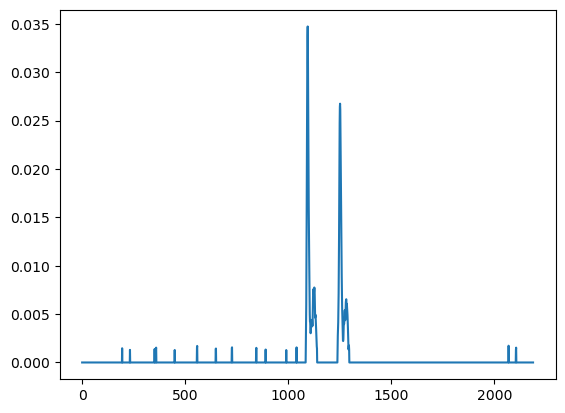

In [9]:
from utils import tirf_utils
if irf_filename is not None:
    irf = tirf_utils.get_irf(irf_filename)
    plt.plot(irf)
    plt.show()

In [10]:
tbin_res = rep_tau / n_tbins
tbin_res_depth = (3e8 * tbin_res) / 2.

print(f'time bin resolution {tbin_res_depth * 1000:.3f} mm')

time bin resolution 13.711 mm


In [5]:
inits = [
        'TruncatedFourier',
        'Greys',
        'experiments/illum_models/n1024_k8_sigma30/checkpoints/coded_model.ckpt',
        'experiments/illum_models/version_1/checkpoints/coded_model.ckpt',
        'experiments/illum_models/version_2/checkpoints/coded_model.ckpt',
        'experiments/illum_models/version_3/checkpoints/coded_model.ckpt',
        'experiments/illum_models/version_4/checkpoints/coded_model.ckpt'
         ]

In [11]:
inits = [
        'TruncatedFourier',
        'Greys',
        'experiments/illum_models/n2188_k8_spaddata/checkpoints/coded_model.ckpt',
        'experiments/illum_models/version_5/checkpoints/coded_model.ckpt',

         ]

In [12]:
sample_data = SampleLabels(n_tbins, sources=counts, sbrs=sbr, num_samples=400, start_bin=360, end_bin=360)
samples = sample_data.labels
depths = torch.tensor([sample[0] for sample in sample_data.labels])
photon_counts = torch.tensor([sample[1] for sample in sample_data.labels])
sbrs = torch.tensor([sample[2] for sample in sample_data.labels])

gt_depths = bin2depth(depths, num_bins=n_tbins, tau=rep_tau)

gt_depths

tensor([ 4.9360,  4.9771,  5.0320,  ..., 24.9543, 25.0091, 25.0640])

Fourier coding K=8
MAE T.Fourier: 1128.413 mm 
Gray coding K=8
MAE Greys: 1293.049 mm 
MAE Ver.spaddata: 605.934 mm 
MAE Ver.5: 1704.737 mm 


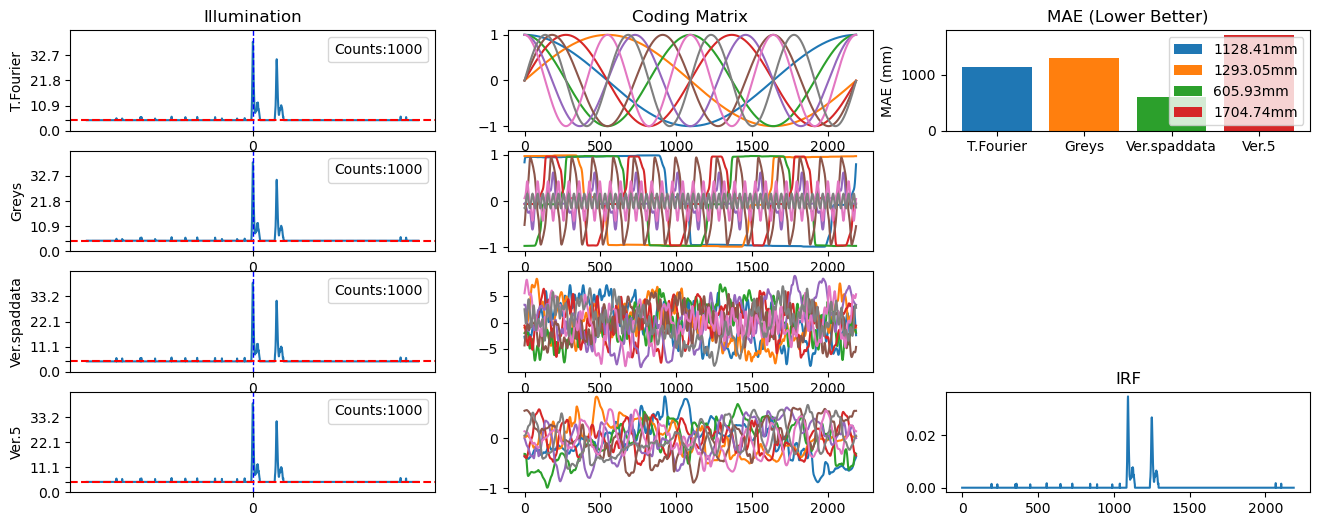

In [13]:
fig, axs = plt.subplots(len(inits), 3, figsize=(16, 6), squeeze=False)
counter = 0
names = []
for init in inits:
    if init.endswith('.ckpt'): 
        get_from_model = True
        with open(os.path.join('experiments/illum_models', init.split('/')[-3], 'hparams.yaml'), 'r') as f:
            hparams = yaml.load(f, Loader=yaml.FullLoader)
            n_tbins_init = hparams['n_tbins']
            k_init = hparams['k']
            recon = hparams['recon']
            #zero_mean=hparams['model_params']['learn_coding_mat']

        name = 'Ver.' + init.split('/')[-3].split('_')[-1]
    elif init == 'TruncatedFourier': 
        get_from_model = False
        k_init = k
        n_tbins_init = n_tbins
        name = 'T.Fourier'
        recon = 'ifft'
        zero_mean=False
    elif init == 'Greys':
        get_from_model = False
        k_init = k
        n_tbins_init = n_tbins
        name = 'Greys'
        recon = 'ncc'
        zero_mean = False

    model = IlluminationLayer(k=k_init, n_tbins=n_tbins_init, init=init, sigma=sigma,
                              irf_filename=irf_filename, get_from_model=get_from_model)

    zncc_layer = ZNCCLayer()
    ncc_layer = NCCLayer(zero_mean)
    ifft_layer = IFFTReconLayer(n_tbins_init)

    c_vals = model(depths, photon_counts, sbrs)

    if recon=='ifft':
        pred_depths = ifft_layer(c_vals)
    elif recon=='zncc':
        pred_depths = zncc_layer(c_vals, model.cmat1D.weight.data.detach().clone())
    elif recon=='ncc':
        pred_depths = ncc_layer(c_vals, model.cmat1D.weight.data.detach().clone())
    else:
         exit(0)
    pred_depths = bin2depth(pred_depths, num_bins=n_tbins_init, tau=rep_tau)
    #print(pred_depths)
    
    #loss = torch.mean(torch.abs(pred_depths.squeeze() - gt_depths.squeeze()))
    loss = criterion_RMSE(pred_depths, gt_depths)

    print(f'MAE {name}: {loss * 1000:.3f} mm ')
    names.append(name)
    cmat = model.cmat1D.weight
    cmat = np.transpose(cmat.detach().numpy().squeeze())

    #illum = model.irf_layer(model.illumination.view(1, n_tbins)).view(n_tbins, 1).numpy().squeeze()
    #illum[illum < 0] = 0
    illum = model.illumination.numpy().squeeze()
    illum = np.roll(model.get_output_illumination(counts[0], sbrs[0]), int(n_tbins // 2))
    sbr_count = float((counts[0] / sbrs[0]) / n_tbins_init)
    axs[counter][0].plot(illum, label=f'Counts:{int(np.sum(illum - sbr_count))}')
    axs[counter][0].axvline(x=int(n_tbins_init // 2), color='blue', linestyle='--', linewidth=1.0)
    axs[counter][0].set_xticks([int(n_tbins_init // 2)])
    axs[counter][0].set_xticklabels([0])
    axs[counter][0].set_yticks(np.append(np.array([sbr_count]), np.round(np.linspace(0, np.max(illum)+5, 5), 1)))
    axs[counter][0].set_yticklabels(np.append(np.array(['']), np.round(np.linspace(0, np.max(illum)+5, 5), 1)))
    axs[counter][0].set_ylabel(name)
    axs[counter][0].set_ylim(0, np.max(illum) + 5)
    axs[counter][0].axhline(y=sbr_count, color='red', linestyle='--')
    axs[counter][0].legend(handlelength=0, handletextpad=0)
    axs[counter][1].plot(cmat)
    
    #axs[counter][1].set_title(init.split('/')[-1].split('.')[0])

    axs[0][2].bar(counter, loss*1000, label=f'{loss * 1000:.2f}mm')
    axs[0][2].set_title('MAE (Lower Better)')
    axs[0][2].set_ylabel('MAE (mm)')


    axs[0][1].set_title('Coding Matrix')
    axs[0][0].set_title('Illumination')

    if counter >= 1 and counter < len(inits)-1:
        axs[counter][2].set_axis_off()

    counter += 1

axs[0][2].set_xticks(np.arange(0, len(inits)))
axs[0][2].set_xticklabels(names)
axs[0][2].legend()


axs[-1][2].plot(np.flip(model.get_irf_func()))
axs[-1][2].set_title('IRF')


plt.show(block=True)
#print(gt_depths)
